<a href="https://colab.research.google.com/github/paulet-art/PredictingTimelyTNBCdiagnosis_WIDS2024/blob/main/EDA%2BENSEMBLE_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting TNBC Diagnosis

Project Overview

Metastatic Triple-Negative Breast Cancer (TNBC) is considered the most aggressive TNBC and requires most urgent and timely treatment. TNBC is characterized by high risk of invasiveness, high metastasis, and poor prognosis. According to the National Institute of Health (2022), more than 1/3 of patients with TNBC experience recirrent or distant metastsis. Early diagnosis and treatment is very important for such difficult cancers. Differences in the wait time to get treatment is a key factor contributing to disparities in healthcare.

The primary goal of this model is to detect the relationship between demographic characteristics and the likelihood of getting timely treatment. Additionally, the model aims to determine whether environmental hazards impact proper diagnosis and treatment. The developed model will predict the likelihood that a patient will be diagnosed with metastatic TNBC within 90 days of screening based on various demographic and environmental factors.

libraries and modules

In [ ]:
pip install catboost lightgbm xgboost scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
from category_encoders import BinaryEncoder
import re
import plotly.graph_objs as go
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#To prevent truncation of output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [ ]:
#Training dataset
train = pd.read_csv("/content/training.csv")

#Test dataset
test = pd.read_csv("/content/test.csv")

#Sample submission
sample_submission = ("/content/sample_submission.csv")

In [ ]:
train.head()

patient_id patient_race  payer_type patient_state  patient_zip3  \
0      475714          NaN    MEDICAID            CA           924   
1      349367        White  COMMERCIAL            CA           928   
2      138632        White  COMMERCIAL            TX           760   
3      617843        White  COMMERCIAL            CA           926   
4      817482          NaN  COMMERCIAL            ID           836   

   patient_age patient_gender    bmi breast_cancer_diagnosis_code  \
0           84              F    NaN                       C50919   
1           62              F  28.49                       C50411   
2           43              F  38.09                       C50112   
3           45              F    NaN                       C50212   
4           55              F    NaN                         1749   

                        breast_cancer_diagnosis_desc  \
0  Malignant neoplasm of unsp site of unspecified...   
1  Malig neoplm of upper-outer quadrant of right ...   
2  Malignant neoplasm of central portion of left ...   
3  Malig neoplasm of upper-inner quadrant of left...   
4  Malignant neoplasm of breast (female), unspeci...   

  metastatic_cancer_diagnosis_code metastatic_first_novel_treatment  \
0                            C7989                              NaN   
1                             C773                              NaN   
2                             C773                              NaN   
3                             C773                              NaN   
4                             C773                              NaN   

  metastatic_first_novel_treatment_type Region            Division  \
0                                   NaN   West             Pacific   
1                                   NaN   West             Pacific   
2                                   NaN  South  West South Central   
3                                   NaN   West             Pacific   
4                                   NaN   West            Mountain   

    population      density  age_median  age_under_10  age_10_to_19  \
0  31437.75000  1189.562500   30.642857     16.014286     15.542857   
1  39121.87879  2295.939394   38.200000     11.878788     13.354545   
2  21996.68333   626.236667   37.906667     13.028333     14.463333   
3  32795.32558  1896.220930   42.871429     10.071429     12.135714   
4  10886.26000   116.886000   43.473469     10.824000     13.976000   

     age_20s    age_30s    age_40s    age_50s    age_60s   age_70s  \
0  17.614286  14.014286  11.614286  11.557143   7.571429  4.000000   
1  14.230303  13.418182  13.333333  14.060606  10.248485  5.951515   
2  12.531667  13.545000  12.860000  12.770000  11.426667  6.565000   
3  12.538095  12.464286  12.650000  14.847619  12.280952  8.216667   
4   9.492000  10.364000  12.600000  14.992000  14.836000  9.462000   

   age_over_80       male     female    married   divorced  never_married  \
0     2.100000  49.857143  50.142857  36.571429  11.885714      47.114286   
1     3.503030  49.893939  50.106061  50.245455   9.827273      35.290909   
2     2.811667  50.123333  49.876667  55.753333  12.330000      27.195000   
3     4.759524  49.066667  50.933333  52.604762  11.623810      31.142857   
4     3.466000  52.312000  47.688000  57.882000  14.964000      21.760000   

    widowed  family_size  family_dual_income  income_household_median  \
0  4.442857     3.928571           52.228571              52996.28571   
1  4.651515     3.622727           61.736364             102741.63640   
2  4.710000     3.260667           55.801667              85984.74138   
3  4.623810     3.098095           54.564286             120533.83330   
4  5.406000     3.352653           47.214286              61075.13043   

   income_household_under_5  income_household_5_to_10  \
0                  3.142857                  4.000000   
1                  2.327273                  1.536364   
2                  2.483333                  1.305000   
3   

In [ ]:
test.head()

patient_id patient_race          payer_type patient_state  patient_zip3  \
0      573710        White            MEDICAID            IN           467   
1      593679          NaN          COMMERCIAL            FL           337   
2      184532     Hispanic            MEDICAID            CA           917   
3      447383     Hispanic  MEDICARE ADVANTAGE            CA           917   
4      687972        Black                 NaN            CA           900   

   patient_age patient_gender   bmi breast_cancer_diagnosis_code  \
0           54              F   NaN                       C50412   
1           52              F   NaN                       C50912   
2           61              F   NaN                       C50911   
3           64              F   NaN                       C50912   
4           40              F  23.0                       C50412   

                        breast_cancer_diagnosis_desc  \
0  Malig neoplasm of upper-outer quadrant of left...   
1  Malignant neoplasm of unspecified site of left...   
2  Malignant neoplasm of unsp site of right femal...   
3  Malignant neoplasm of unspecified site of left...   
4  Malig neoplasm of upper-outer quadrant of left...   

  metastatic_cancer_diagnosis_code metastatic_first_novel_treatment  \
0                             C773                              NaN   
1                             C787                              NaN   
2                             C773                              NaN   
3                             C779                              NaN   
4                             C779                              NaN   

  metastatic_first_novel_treatment_type   Region            Division  \
0                                   NaN  Midwest  East North Central   
1                                   NaN    South      South Atlantic   
2                                   NaN     West             Pacific   
3                                   NaN     West             Pacific   
4                                   NaN     West             Pacific   

     population      density  age_median  age_under_10  age_10_to_19  \
0   5441.435484    85.620968   40.880328     12.732258     14.088710   
1  19613.820510  1555.107692   49.107692      8.069231      8.587179   
2  43030.500000  2048.578261   38.852174     11.306522     12.897826   
3  43030.500000  2048.578261   38.852174     11.306522     12.897826   
4  36054.117650  5294.330882   36.653846      9.761538     11.267692   

     age_20s    age_30s    age_40s    age_50s    age_60s    age_70s  \
0  10.659677  11.625806  11.208065  15.619355  12.322581   8.409677   
1  10.684615  11.302564  10.971795  15.823077  15.902564  11.828205   
2  14.121739  13.532609  13.160870  13.378261  11.473913   6.380435   
3  14.121739  13.532609  13.160870  13.378261  11.473913   6.380435   
4  17.233846  17.441538  13.090769  12.304615   9.407692   5.673846   

   age_over_80       male     female    married   divorced  never_married  \
0     3.343548  49.154839  50.845161  55.175806  13.982258      24.266129   
1     6.815385  49.658974  50.341026  44.800000  17.779487      29.102564   
2     3.736957  49.052174  50.947826  48.504348  10.117391      36.408696   
3     3.736957  49.052174  50.947826  48.504348  10.117391      36.408696   
4     3.824615  50.510769  49.489231  33.478462  11.301538      50.456923   

    widowed  family_size  family_dual_income  income_household_median  \
0  6.583871     3.073226           52.980645              66187.22807   
1  8.310256     2.917105           46.665789              64711.71053   
2  4.969565     3.674783           59.219565              86330.39130   
3  4.969565     3.674783           59.219565              86330.39130   
4  4.766154     3.442857           55.531746              69266.69355   

   income_household_under_5  income_household_5_to_10  \
0                  1.611290                  1.277419   
1                  3.873684                  2.04473

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

## **Statistical Summary of data:**

In [ ]:
train.describe()

patient_id  patient_zip3   patient_age          bmi    population  \
count   12906.000000  12906.000000  12906.000000  3941.000000  12905.000000   
mean   547381.196033    573.754300     59.183326    28.984539  20744.441237   
std    260404.959974    275.447534     13.335216     5.696906  13886.903756   
min    100063.000000    101.000000     18.000000    14.000000    635.545455   
25%    321517.000000    331.000000     50.000000    24.660000   9463.896552   
50%    543522.000000    554.000000     59.000000    28.190000  19154.190480   
75%    772671.750000    846.000000     67.000000    32.920000  30021.278690   
max    999896.000000    999.000000     91.000000    85.000000  71374.131580   

            density    age_median  age_under_10  age_10_to_19       age_20s  \
count  12905.000000  12905.000000  12905.000000  12905.000000  12905.000000   
mean    1581.950419     40.502259     11.122784     12.945265     13.290376   
std     2966.305306      4.036963      1.512376      1.923974      3.354103   
min        0.916667     20.600000      0.000000      6.314286      5.925000   
25%      171.857143     37.129825     10.160000     11.741176     11.013415   
50%      700.337500     40.639344     11.039216     12.923944     12.538095   
75%     1666.515385     42.934783     12.190000     14.019767     14.971053   
max    21172.000000     54.570000     17.675000     35.300000     62.100000   

            age_30s       age_40s       age_50s       age_60s       age_70s  \
count  12905.000000  12905.000000  12905.000000  12905.000000  12905.000000   
mean      12.862036     12.066978     13.441936     12.620903      7.653389   
std        2.324922      1.248499      1.643221      2.571528      2.147138   
min        1.500000      0.800000      0.000000      0.200000      0.000000   
25%       11.292105     11.340299     12.304615     10.623810      6.010811   
50%       12.442647     12.124074     13.568254     12.533333      7.316901   
75%       14.026667     12.892308     14.575556     13.985714      8.790625   
max       25.471429     17.820000     21.661111     29.854545     19.000000   

        age_over_80          male        female       married      divorced  \
count  12905.000000  12905.000000  12905.000000  12905.000000  12905.000000   
mean       3.996221     50.095180     49.904900     47.680767     12.670532   
std        1.236823      1.656640      1.656594      7.491146      2.047935   
min        0.000000     39.725000     38.400000      0.900000      0.200000   
25%        3.284615     49.158333     49.062069     42.931250     11.163158   
50%        3.800000     49.976042     50.023958     49.434091     12.653125   
75%        4.532258     50.937931     50.841667     52.994340     14.188000   
max       18.825000     61.600000     60.275000     66.903333     19.831034   

       never_married       widowed   family_size  family_dual_income  \
count   12905.000000  12905.000000  12902.000000        12902.000000   
mean       33.834497      5.813387      3.202241           51.848542   
std         8.019483      1.537171      0.224519            6.807659   
min        13.440000      0.000000      2.550370           19.312121   
25%        27.526154      4.764286      3.038780           47.643103   
50%        32.003659      5.520833      3.166462           52.591837   
75%        39.229032      6.521875      3.352500           56.614286   
max        98.900000     23.054545      4.172273           70.925000   

       income_household_median  income_household_under_5  \
count             12902.000000              12902.000000   
mean              74374.366908                  3.269565   
std               20712.590100                  1.448217   
min               29222.000000                  0.750000   
25%               61284.453330                  2.255556   
50%               69803.125000                  2.838235   
75%               83539.000000                  4.013559   
max              164119.176500   

In [ ]:
test.describe()

patient_id  patient_zip3  patient_age          bmi    population  \
count    5792.000000   5792.000000  5792.000000  1777.000000   5792.000000   
mean   549946.787983    570.217887    59.274862    28.900073  20266.872152   
std    260988.833446    275.314510    13.076323     5.609491  13694.738314   
min    100266.000000    101.000000    18.000000    14.000000    829.515152   
25%    320284.500000    329.000000    50.000000    24.600000   8863.550000   
50%    553042.000000    554.000000    59.000000    28.150000  18711.016665   
75%    778552.250000    836.000000    67.000000    32.860000  28996.772730   
max    999890.000000    996.000000    91.000000    43.900000  71374.131580   

            density   age_median  age_under_10  age_10_to_19      age_20s  \
count   5792.000000  5792.000000   5792.000000   5792.000000  5792.000000   
mean    1510.471786    40.575472     11.119250     12.919191    13.218348   
std     2883.409750     4.029852      1.478579      1.909698     3.294389   
min        0.821739    20.600000      0.000000      6.314286     5.925000   
25%      161.925000    37.190476     10.160000     11.726471    10.996226   
50%      626.236667    40.640909     11.039216     12.923944    12.531646   
75%     1612.851111    43.085938     12.143396     13.904830    14.937500   
max    21172.000000    54.570000     16.481818     35.300000    62.100000   

           age_30s      age_40s      age_50s      age_60s      age_70s  \
count  5792.000000  5792.000000  5792.000000  5792.000000  5792.000000   
mean     12.841374    12.063877    13.445992    12.669871     7.708020   
std       2.358636     1.250266     1.607599     2.584994     2.172747   
min       1.500000     0.800000     0.000000     0.200000     0.000000   
25%      11.211818    11.354237    12.304615    10.642553     6.010527   
50%      12.404348    12.118605    13.572990    12.535714     7.380952   
75%      14.037838    12.867171    14.540741    14.091549     8.934848   
max      25.471429    17.820000    21.661111    26.457895    16.270833   

       age_over_80         male       female      married     divorced  \
count  5792.000000  5792.000000  5792.000000  5792.000000  5792.000000   
mean      4.013545    50.101101    49.898977    47.785025    12.741028   
std       1.240229     1.667512     1.667478     7.449499     2.050688   
min       0.000000    39.725000    38.400000     0.900000     0.200000   
25%       3.284615    49.257353    49.081395    42.989464    11.220536   
50%       3.814044    49.989744    50.010256    49.665574    12.800000   
75%       4.556897    50.918605    50.742647    52.994340    14.200000   
max      18.825000    61.600000    60.275000    62.697368    21.033333   

       never_married      widowed  family_size  family_dual_income  \
count    5792.000000  5792.000000  5791.000000         5791.000000   
mean       33.603883     5.869018     3.200133           51.743661   
std         8.028668     1.553876     0.225862            6.783944   
min        18.294444     0.000000     2.550370           26.714286   
25%        27.201818     4.766154     3.036364           47.525926   
50%        31.928889     5.572549     3.164286           52.343333   
75%        38.642623     6.708621     3.332055           56.190385   
max        98.900000    20.650000     4.172273           70.925000   

       income_household_median  income_household_under_5  \
count              5791.000000               5791.000000   
mean              73804.632684                  3.272925   
std               20512.986299                  1.447294   
min               32935.384620                  0.750000   
25%               60952.268290                  2.265217   
50%               69407.350000                  2.851429   
75%               82486.027030                  4.010526   
max              164119.176500                 19.620000   

       income_household_5_to_10  income_household_10_to_15  \
count               5791.000000              

## **Data Cleaning**

#### Missing Data

<Axes: >

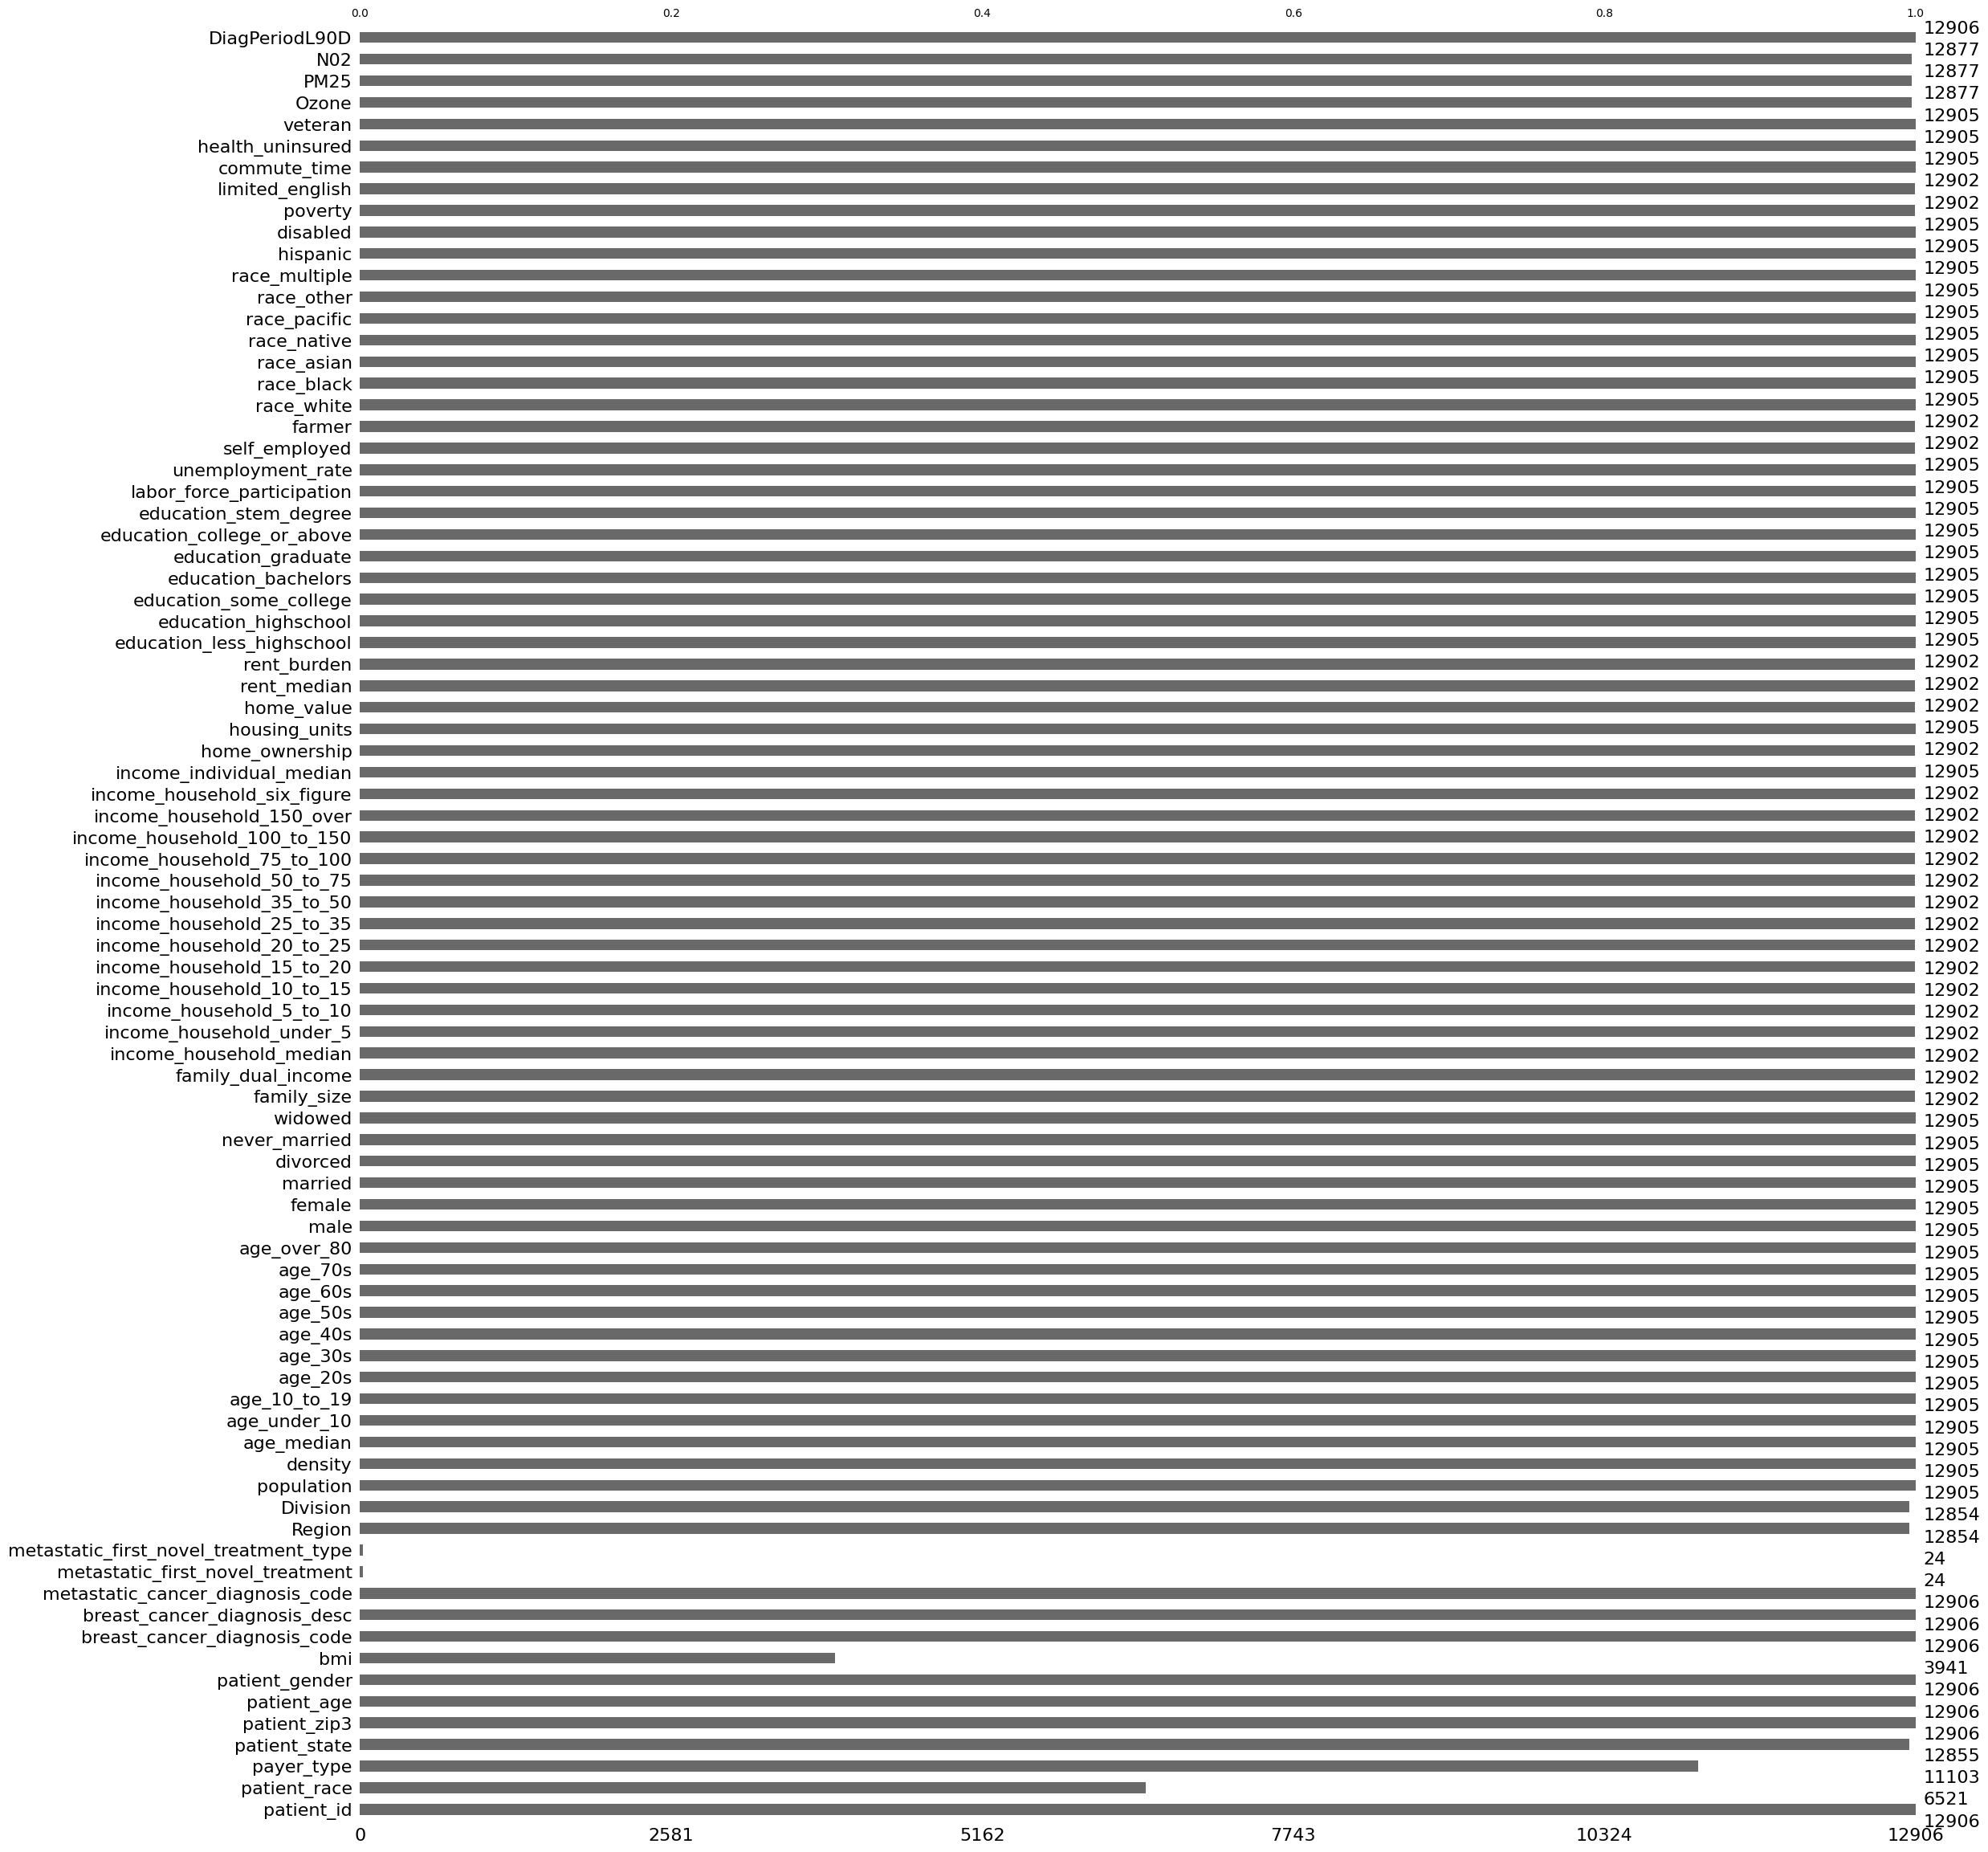

In [ ]:
#using Missingno module to visualize the distribution of missing data
msn.bar(train)

The bar chart above shows some columns with significantly high numbers of missing data, with some having almost all data missing. Understanding percentages of the missing data will help to better determine best approaches to handle the columns with missing data.

In [ ]:
# Calculate the percentage of missing values for each column
missing_percentage = (train.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
missing_info = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing Percentage': missing_percentage.values
})
missing_info["Missing Percentage"] = missing_info["Missing Percentage"].astype(float)

missing_info.sort_values(by='Missing Percentage', ascending=False)

Column  Missing Percentage
11       metastatic_first_novel_treatment               99.81
12  metastatic_first_novel_treatment_type               99.81
7                                     bmi               69.46
1                            patient_race               49.47
2                              payer_type               13.97
3                           patient_state                0.40
13                                 Region                0.40
14                               Division                0.40
81                                    N02                0.22
80                                   PM25                0.22
79                                  Ozone                0.22
41              income_household_25_to_35                0.03
39              income_household_15_to_20                0.03
42              income_household_35_to_50                0.03
40              income_household_20_to_25                0.03
75                        limited_english                0.03
38              income_household_10_to_15                0.03
44             income_household_75_to_100                0.03
36               income_household_under_5                0.03
35                income_household_median                0.03
43              income_household_50_to_75                0.03
51                             home_value                0.03
45            income_household_100_to_150                0.03
46              income_household_150_over                0.03
47            income_household_six_figure                0.03
49                         home_ownership                0.03
33                            family_size                0.03
52                            rent_median                0.03
53                            rent_burden                0.03
63                          self_employed                0.03
64                                 farmer                0.03
34                     family_dual_income                0.03
37               income_household_5_to_10                0.03
74                                poverty                0.03
78                                veteran                0.01
56                 education_some_college                0.01
57                    education_bachelors                0.01
58                     education_graduate                0.01
59             education_college_or_above                0.01
60                  education_stem_degree                0.01
61              labor_force_participation                0.01
62                      unemployment_rate                0.01
77                       health_uninsured                0.01
65                             race_white                0.01
31                          never_married                0.01
66                             race_black                0.01
67                             race_asian                0.01
68                            race_native                0.01
69                           race_pacific                0.01
70                             race_other                0.01
71                          race_multiple                0.01
72                               hispanic                0.01
73                               disabled                0.01
55                   education_highschool                0.01
32                                widowed                0.01
76                           commute_time                0.01
15                             population                0.01
30                               divorced                0.01
29                                married                0.01
28                                 female                0.01
27                                   male                0.01
26                            age_over_80                0.01
25                                age_70s                0.01
24                                age_60s                0.01
23   

In [ ]:

missing_info[missing_info['Missing Percentage'] > 0]

Column  Missing Percentage
1                            patient_race               49.47
2                              payer_type               13.97
3                           patient_state                0.40
7                                     bmi               69.46
11       metastatic_first_novel_treatment               99.81
12  metastatic_first_novel_treatment_type               99.81
13                                 Region                0.40
14                               Division                0.40
15                             population                0.01
16                                density                0.01
17                             age_median                0.01
18                           age_under_10                0.01
19                           age_10_to_19                0.01
20                                age_20s                0.01
21                                age_30s                0.01
22                                age_40s                0.01
23                                age_50s                0.01
24                                age_60s                0.01
25                                age_70s                0.01
26                            age_over_80                0.01
27                                   male                0.01
28                                 female                0.01
29                                married                0.01
30                               divorced                0.01
31                          never_married                0.01
32                                widowed                0.01
33                            family_size                0.03
34                     family_dual_income                0.03
35                income_household_median                0.03
36               income_household_under_5                0.03
37               income_household_5_to_10                0.03
38              income_household_10_to_15                0.03
39              income_household_15_to_20                0.03
40              income_household_20_to_25                0.03
41              income_household_25_to_35                0.03
42              income_household_35_to_50                0.03
43              income_household_50_to_75                0.03
44             income_household_75_to_100                0.03
45            income_household_100_to_150                0.03
46              income_household_150_over                0.03
47            income_household_six_figure                0.03
48               income_individual_median                0.01
49                         home_ownership                0.03
50                          housing_units                0.01
51                             home_value                0.03
52                            rent_median                0.03
53                            rent_burden                0.03
54              education_less_highschool                0.01
55                   education_highschool                0.01
56                 education_some_college                0.01
57                    education_bachelors                0.01
58                     education_graduate                0.01
59             education_college_or_above                0.01
60                  education_stem_degree                0.01
61              labor_force_participation                0.01
62                      unemployment_rate                0.01
63                          self_employed                0.03
64                                 farmer                0.03
65                             race_white                0.01
66                             race_black                0.01
67                             race_asian                0.01
68                            race_native                0.01
69                           race_pacific                0.01
70                             race_other                0.01
71   

The percentage of missing values in the following columns are between 49.5% and 99.8%. These values are too high to be useful to the model; hence, we will drop these columns;
- Patient race
- metastatic first novel treatment
- metastatic first novel treatment type

For the rest of the columns with low percentages of null rows, the missing data will be imputed with estimated values based on each column's needs

<Axes: >

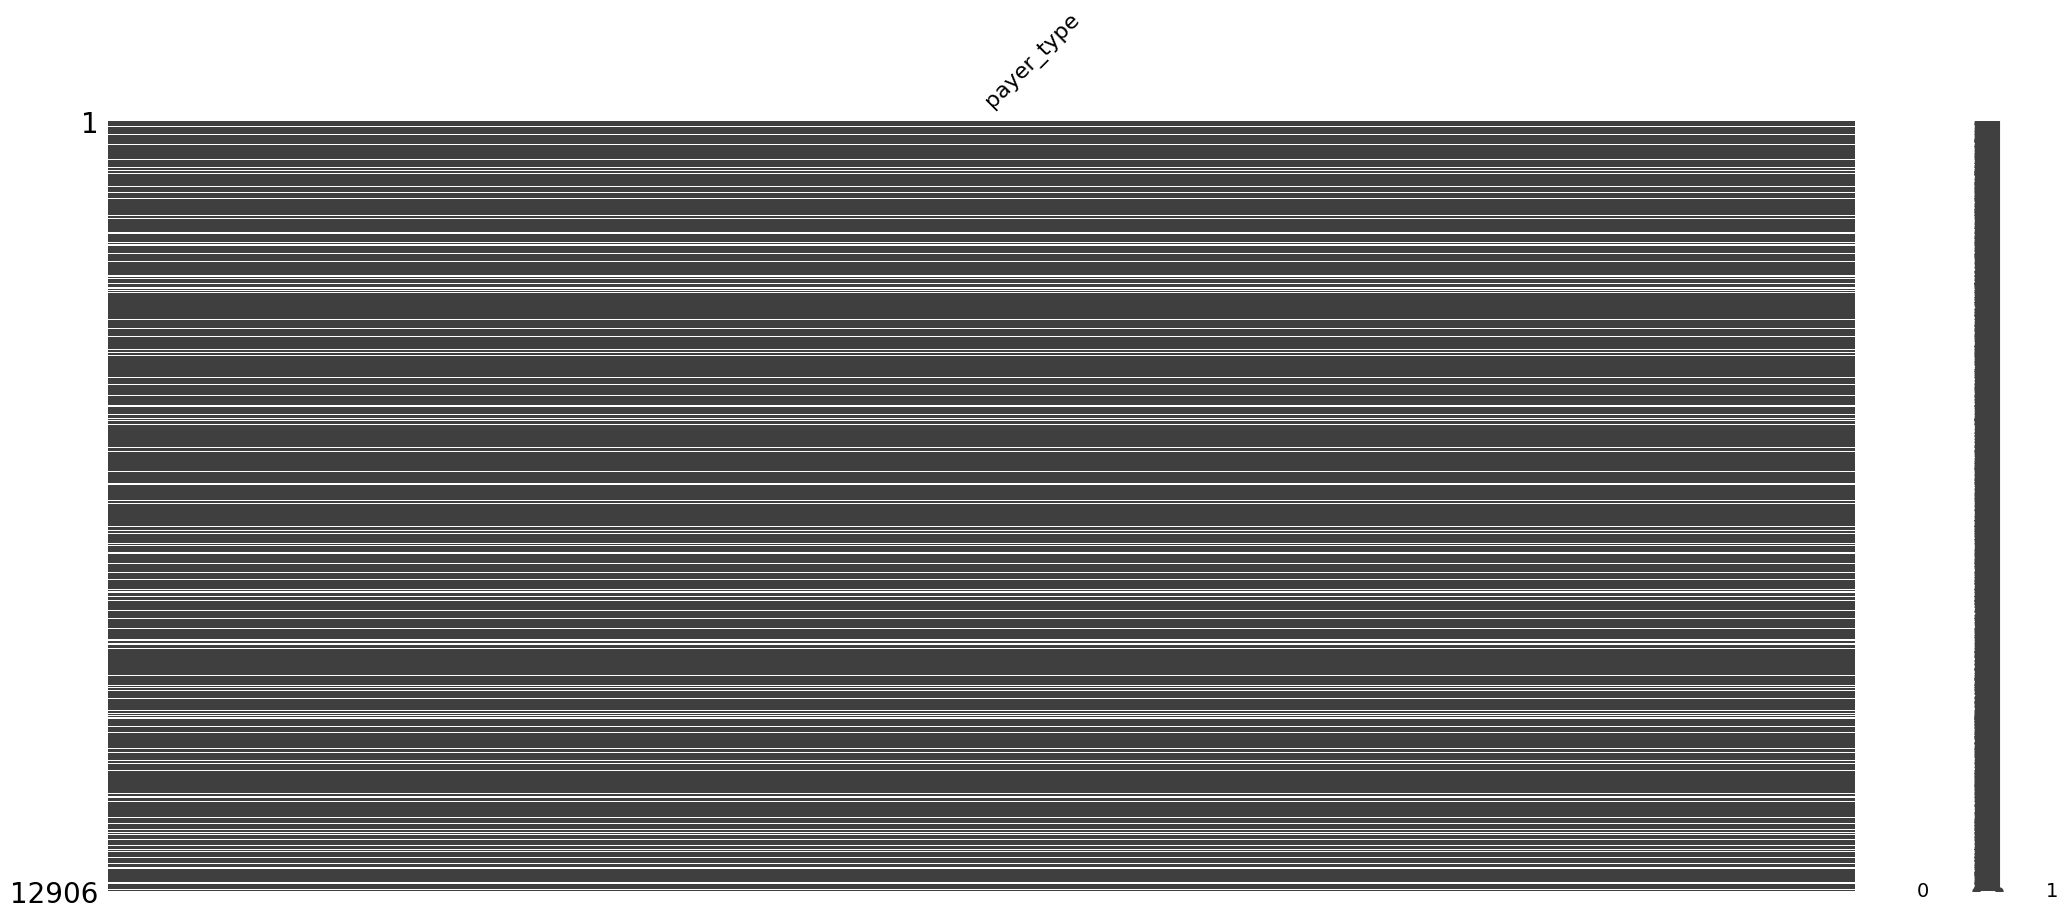

In [ ]:
#Checking whether there is a pattern in the missingness; the data in this column seems to be missing at random
payer_type_subset = pd.DataFrame(train['payer_type'])
msn.matrix(payer_type_subset)

In [ ]:
#impute the missing rows with "UNKNOWN"
train['payer_type'].fillna('UNKNOWN', inplace=True)
train['payer_type'].value_counts()

COMMERCIAL            6032
MEDICAID              2569
MEDICARE ADVANTAGE    2502
UNKNOWN               1803
Name: payer_type, dtype: int64

In [ ]:
"""Checking skewness to determine if there may be concerns
about imputing numeric columns with the mean
(if column data too skewed, better option would be the mode)"""

for column in train:
    if train[column].isna().sum() > 0:
        if train[column].dtype == 'int64' or train[column].dtype == 'float64':
            skewness = train[column].skew()
            print(column, " ", skewness)

bmi   0.7374710199541298
population   0.9976671384912528
density   4.040191665611303
age_median   0.2941740292306184
age_under_10   -0.10988419260321437
age_10_to_19   1.2568177691518527
age_20s   2.117028165248512
age_30s   0.9549065888784517
age_40s   -0.325615805997724
age_50s   -0.13337023559548006
age_60s   0.6754506355981723
age_70s   1.0895315157874546
age_over_80   2.6328256973902855
male   0.7660630840604239
female   -0.7661423950331259
married   -0.7687232087616692
divorced   0.0582554772468598
never_married   0.8518544038149493
widowed   1.5378307232152508
family_size   0.7537053879492308
family_dual_income   -0.510570700961349
income_household_median   1.111185208028617
income_household_under_5   1.9201271976022671
income_household_5_to_10   1.6025294282010825
income_household_10_to_15   1.0205072914126039
income_household_15_to_20   0.8693404446923003
income_household_20_to_25   0.714677547710587
income_household_25_to_35   0.13590773021585764
income_household_35_to_50   -

In [ ]:
"""This code imputes data to remaining columns of missing data

If column data type is numeric, column is imputed with the mean value of the respective column

If the column data type is an object, column is imputed with the mode of the respective column"""


for column in train:

    if train[column].isna().sum() > 0:
        if train[column].dtype == "float64" or train[column].dtype == "int64":

            # Fill missing values for numeric columns with the mean of each column
            train[column] = train[column].fillna(train[column].mean())

        else:  # column data type is object

            # Fill missing values for object columns with the mode of each column
            train[column] = train[column].fillna(train[column].mode().iloc[0])


In [ ]:
"""This code imputes data to remaining columns of missing data

If column data type is numeric, column is imputed with the mean value of the respective column

If the column data type is an object, column is imputed with the mode of the respective column"""


for column in test:

    if test[column].isna().sum() > 0:
        if test[column].dtype == "float64" or test[column].dtype == "int64":

            # Fill missing values for numeric columns with the mean of each column
            test[column] = test[column].fillna(test[column].mean())

        else:  # column data type is object

            # Fill missing values for object columns with the mode of each column
            test[column] = test[column].fillna(test[column].mode().iloc[0])


In [ ]:
test.isna().sum()

patient_id                               0
patient_race                             0
payer_type                               0
patient_state                            0
patient_zip3                             0
patient_age                              0
patient_gender                           0
bmi                                      0
breast_cancer_diagnosis_code             0
breast_cancer_diagnosis_desc             0
metastatic_cancer_diagnosis_code         0
metastatic_first_novel_treatment         0
metastatic_first_novel_treatment_type    0
Region                                   0
Division                                 0
population                               0
density                                  0
age_median                               0
age_under_10                             0
age_10_to_19                             0
age_20s                                  0
age_30s                                  0
age_40s                                  0
age_50s    

In [ ]:
#No more missing data :)

train.isna().sum()

patient_id                               0
patient_race                             0
payer_type                               0
patient_state                            0
patient_zip3                             0
patient_age                              0
patient_gender                           0
bmi                                      0
breast_cancer_diagnosis_code             0
breast_cancer_diagnosis_desc             0
metastatic_cancer_diagnosis_code         0
metastatic_first_novel_treatment         0
metastatic_first_novel_treatment_type    0
Region                                   0
Division                                 0
population                               0
density                                  0
age_median                               0
age_under_10                             0
age_10_to_19                             0
age_20s                                  0
age_30s                                  0
age_40s                                  0
age_50s    

### EDA

In [ ]:
histogram = px.histogram(train, x='patient_age', color='DiagPeriodL90D')
histogram.update_layout(title='Histogram of Patient Age by DiagPeriodL90D')
histogram.show()

In the dataset being analyzed, there are 305 individuals who are 64 years old, making them the largest group among all age categories in terms of diagnosis count. This indicates that individuals at the age of 64 represent the highest frequency of diagnosis compared to other age groups.

In [ ]:
scatter_plot = px.scatter(train, x='patient_age', y='metastatic_cancer_diagnosis_code', color='DiagPeriodL90D')
scatter_plot.show()

In the scatter plot, the patient aged 91 represents the oldest individual to receive a diagnosis, while the patient aged 18 is the youngest. This information is valuable for understanding the range of ages among patients diagnosed with metastatic cancer and provides insights into the age distribution within the dataset.

In [ ]:
# Plot age vs. breast cancer diagnosis code
age_diagnosis_plot = px.scatter(train, x='patient_age', y='breast_cancer_diagnosis_code',
                                title='Age vs. Breast Cancer Diagnosis Code',
                                labels={'patient_age': 'Patient Age', 'breast_cancer_diagnosis_code': 'Diagnosis Code'})

# Show the plot
age_diagnosis_plot.show()

In [ ]:
# Filter data for patients diagnosed with breast cancer
breast_cancer_patients = train[train['breast_cancer_diagnosis_code'].notnull()]

# Count the number of patients diagnosed with both breast cancer and metastatic cancer
breast_metastatic_counts = breast_cancer_patients.groupby('metastatic_cancer_diagnosis_code').size().reset_index(name='count')

# Plot the bar chart
breast_metastatic_plot = px.bar(breast_metastatic_counts, x='metastatic_cancer_diagnosis_code', y='count',
                                 title='Patients Diagnosed with Breast Cancer and Metastatic Cancer',
                                 labels={'metastatic_cancer_diagnosis_code': 'Metastatic Cancer Diagnosis Code', 'count': 'Number of Patients'})

# Show the plot
breast_metastatic_plot.show()

In [ ]:
bar_plot = px.bar(train['breast_cancer_diagnosis_code'].value_counts().reset_index(), x='index', y='breast_cancer_diagnosis_code',
                  labels={'index': 'Diagnosis Code', 'breast_cancer_diagnosis_code': 'Frequency'},
                  title='Frequency of Breast Cancer Diagnosis Codes')
bar_plot.show()

In [ ]:
# Filter data for patients with metastatic cancer diagnosis code
metastatic_patients = train[train['metastatic_cancer_diagnosis_code'].notnull()]

# Group data by breast cancer diagnosis code and count the number of patients for each
breast_cancer_count = metastatic_patients.groupby('breast_cancer_diagnosis_code').size().reset_index(name='count')

# Plot bar chart for count of patients with metastatic cancer diagnosis code for each breast cancer diagnosis code
bar_chart = px.bar(breast_cancer_count, x='breast_cancer_diagnosis_code', y='count',
                   title='Count of Patients with Metastatic Cancer Diagnosis Code for Each Breast Cancer Diagnosis Code',
                   labels={'breast_cancer_diagnosis_code': 'Breast Cancer Diagnosis Code', 'count': 'Count'})

# Show the plot
bar_chart.show()


The high count of 7056 individuals associated with the C773 code suggests that this particular type of metastasis related to breast cancer is relatively common or has been frequently documented in the dataset.

In [ ]:
# Pie chart for patient race distribution
race_distribution = train['patient_race'].value_counts()
race_pie_chart = px.pie(names=race_distribution.index, values=race_distribution.values, title='Distribution of Patient Race')
race_pie_chart.show()

In [ ]:
# Bar chart for payer type distribution
payer_distribution = train['payer_type'].value_counts()
payer_bar_chart = px.bar(x=payer_distribution.index, y=payer_distribution.values, title='Distribution of Payer Type')
payer_bar_chart.show()


In [ ]:
# Histogram for patient age distribution
age_histogram = px.histogram(train, x='patient_age', title='Distribution of Patient Age')
age_histogram.show()

In [ ]:
# Scatter plot for patient age vs. BMI
age_bmi_scatter = px.scatter(train, x='patient_age', y='bmi', title='Patient Age vs. BMI',
                              labels={'patient_age': 'Patient Age', 'bmi': 'BMI'})
age_bmi_scatter.show()

In [ ]:
# Line plot for ozone, PM2.5, and NO2 concentrations over different zip codes
ozone_pm25_no2_line = px.line(train, title='Ozone, PM2.5, and NO2 Concentrations over Zip Codes',
                              x='patient_id', y=['Ozone', 'PM25', 'N02'], color='patient_zip3')

# Displaying the plot
ozone_pm25_no2_line.show()

Encodings

In [ ]:
cols_to_encode = [ 'payer_type', 'Region', 'patient_state', 'patient_zip3', 'Division', 'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_code']
binary_encoder = BinaryEncoder(cols=cols_to_encode)
train = binary_encoder.fit_transform(train)
train.head()



patient_id patient_race  payer_type_0  payer_type_1  payer_type_2  \
0      475714        White             0             0             1   
1      349367        White             0             1             0   
2      138632        White             0             1             0   
3      617843        White             0             1             0   
4      817482        White             0             1             0   

   patient_state_0  patient_state_1  patient_state_2  patient_state_3  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   patient_state_4  patient_state_5  patient_zip3_0  patient_zip3_1  \
0                0                1               0               0   
1                0                1               0               0   
2                1                0               0               0   
3                0                1               0               0   
4                1                1               0               0   

   patient_zip3_2  patient_zip3_3  patient_zip3_4  patient_zip3_5  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   patient_zip3_6  patient_zip3_7  patient_zip3_8  patient_zip3_9  \
0               0               0               0               1   
1               0               0               1               0   
2               0               0               1               1   
3               0               1               0               0   
4               0               1               0               1   

   patient_age patient_gender        bmi  breast_cancer_diagnosis_code_0  \
0           84              F  28.984539                               0   
1           62              F  28.490000                               0   
2           43              F  38.090000                               0   
3           45              F  28.984539                               0   
4           55              F  28.984539                               0   

   breast_cancer_diagnosis_code_1  breast_cancer_diagnosis_code_2  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   breast_cancer_diagnosis_code_3  breast_cancer_diagnosis_code_4  \
0                               0                               0   
1                               0                               1   
2                               0                               1   
3                               1                               0   
4                               1                               0   

   breast_cancer_diagnosis_code_5  \
0                               1   
1                               0   
2                               1   
3                               0   
4                               1   

                        breast_cancer_diagnosis_desc  \
0  Malignant neoplasm of unsp site of unspecified...   
1  Malig neoplm of upper-outer quadrant of right ...   
2  Malignant neoplasm of central portion of left ...   
3  Malig neoplasm of upper-inner quadrant of left...   
4  Malignant neoplasm of breast (female), unspeci...   

   metastatic_cancer_diagno

In [ ]:
test.columns.to_list()

['patient_id',
 'patient_race',
 'payer_type',
 'patient_state',
 'patient_zip3',
 'patient_age',
 'patient_gender',
 'bmi',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code',
 'metastatic_first_novel_treatment',
 'metastatic_first_novel_treatment_type',
 'Region',
 'Division',
 'population',
 'density',
 'age_median',
 'age_under_10',
 'age_10_to_19',
 'age_20s',
 'age_30s',
 'age_40s',
 'age_50s',
 'age_60s',
 'age_70s',
 'age_over_80',
 'male',
 'female',
 'married',
 'divorced',
 'never_married',
 'widowed',
 'family_size',
 'family_dual_income',
 'income_household_median',
 'income_household_under_5',
 'income_household_5_to_10',
 'income_household_10_to_15',
 'income_household_15_to_20',
 'income_household_20_to_25',
 'income_household_25_to_35',
 'income_household_35_to_50',
 'income_household_50_to_75',
 'income_household_75_to_100',
 'income_household_100_to_150',
 'income_household_150_over',
 'income_household_six_figure',


In [ ]:
cols_to_encode = [ 'payer_type', 'Region', 'patient_state', 'patient_zip3', 'Division', 'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_code']
binary_encoder = BinaryEncoder(cols=cols_to_encode)
test = binary_encoder.fit_transform(test)
test.head()



patient_id patient_race  payer_type_0  payer_type_1  patient_state_0  \
0      573710        White             0             1                0   
1      593679        White             1             0                0   
2      184532     Hispanic             0             1                0   
3      447383     Hispanic             1             1                0   
4      687972        Black             1             0                0   

   patient_state_1  patient_state_2  patient_state_3  patient_state_4  \
0                0                0                0                0   
1                0                0                0                1   
2                0                0                0                1   
3                0                0                0                1   
4                0                0                0                1   

   patient_state_5  patient_zip3_0  patient_zip3_1  patient_zip3_2  \
0                1               0               0               0   
1                0               0               0               0   
2                1               0               0               0   
3                1               0               0               0   
4                1               0               0               0   

   patient_zip3_3  patient_zip3_4  patient_zip3_5  patient_zip3_6  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   patient_zip3_7  patient_zip3_8  patient_zip3_9  patient_age patient_gender  \
0               0               0               1           54              F   
1               0               1               0           52              F   
2               0               1               1           61              F   
3               0               1               1           64              F   
4               1               0               0           40              F   

         bmi  breast_cancer_diagnosis_code_0  breast_cancer_diagnosis_code_1  \
0  28.900073                               0                               0   
1  28.900073                               0                               0   
2  28.900073                               0                               0   
3  28.900073                               0                               0   
4  23.000000                               0                               0   

   breast_cancer_diagnosis_code_2  breast_cancer_diagnosis_code_3  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   breast_cancer_diagnosis_code_4  breast_cancer_diagnosis_code_5  \
0                               0                               1   
1                               1                               0   
2                               1                               1   
3                               1                               0   
4                               0                               1   

                        breast_cancer_diagnosis_desc  \
0  Malig neoplasm of upper-outer quadrant of left...   
1  Malignant neoplasm of unspecified site of left...   
2  Malignant neoplasm of unsp site of right femal...   
3  Malignant neoplasm of unspecified site of left...   
4  Malig neoplasm of upper-outer quadrant of left...   

   metastatic_cancer_diagnosis_code_0  metastatic_cancer_diagnosis_code_1  \
0                                   0                            

## NLP

In [ ]:

train['breast_cancer_diagnosis_desc'].head(20)

0     Malignant neoplasm of unsp site of unspecified...
1     Malig neoplm of upper-outer quadrant of right ...
2     Malignant neoplasm of central portion of left ...
3     Malig neoplasm of upper-inner quadrant of left...
4     Malignant neoplasm of breast (female), unspeci...
5     Malignant neoplasm of breast (female), unspeci...
6     Malignant neoplasm of unspecified site of left...
7     Malig neoplasm of lower-outer quadrant of left...
8     Malignant neoplasm of upper-outer quadrant of ...
9     Malignant neoplasm of unspecified site of left...
10    Malig neoplasm of upper-outer quadrant of left...
11    Malignant neoplasm of breast (female), unspeci...
12    Malignant neoplasm of ovrlp sites of left fema...
13    Malignant neoplasm of breast (female), unspeci...
14    Malignant neoplasm of unsp site of right femal...
15    Malig neoplm of upper-outer quadrant of right ...
16    Malignant neoplasm of breast (female), unspeci...
17    Malignant neoplasm of unsp site of right f

In [ ]:
test['breast_cancer_diagnosis_desc'].head(20)

0     Malig neoplasm of upper-outer quadrant of left...
1     Malignant neoplasm of unspecified site of left...
2     Malignant neoplasm of unsp site of right femal...
3     Malignant neoplasm of unspecified site of left...
4     Malig neoplasm of upper-outer quadrant of left...
5     Malignant neoplasm of other specified sites of...
6     Malignant neoplasm of unspecified site of left...
7     Malig neoplasm of upper-inner quadrant of left...
8     Malignant neoplasm of unsp site of unspecified...
9     Malig neoplasm of upper-outer quadrant of left...
10    Malignant neoplasm of unsp site of unspecified...
11    Malignant neoplasm of breast (female), unspeci...
12    Malignant neoplasm of breast (female), unspeci...
13    Malignant neoplasm of unspecified site of left...
14    Malignant neoplasm of central portion of left ...
15    Malignant neoplasm of ovrlp sites of right fem...
16    Malig neoplm of lower-outer quadrant of right ...
17    Malignant neoplasm of ovrlp sites of left 

In [ ]:
import re
from nltk.corpus import stopwords
import nltk

# Download NLTK resources (only need to do this once)
nltk.download('stopwords')

# Function to remove stopwords and spaces
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    filtered_text = ''.join(filtered_tokens)
    return filtered_text

# Function to clean breast cancer diagnosis description
def clean_breast_cancer_diagnosis_desc(text):
    # Removing unnecessary characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Conversion to lowercase
    text = text.lower()

    # Normalize Incomplete Words
    text = re.sub(r'\bmalig\b', 'malignant', text)
    text = re.sub(r'\bneoplm\b', 'neoplasm', text)
    text = re.sub(r'\bunsp\b', 'unspecified', text)

    # Remove double quotes and brackets
    text = text.replace('"', '').replace('(', '').replace(')', '')
    text = text.replace('-', '')

    return text

# Apply stopwords removal
train['clean_breast_cancer_diagnosis_desc_stopwords_removed'] = train['breast_cancer_diagnosis_desc'].apply(remove_stopwords)

# Apply cleaning function
train['clean_breast_cancer_diagnosis_desc'] = train['clean_breast_cancer_diagnosis_desc_stopwords_removed'].apply(clean_breast_cancer_diagnosis_desc)

# Display cleaned data
print(train[['breast_cancer_diagnosis_desc', 'clean_breast_cancer_diagnosis_desc']])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                            breast_cancer_diagnosis_desc  \
0      Malignant neoplasm of unsp site of unspecified...   
1      Malig neoplm of upper-outer quadrant of right ...   
2      Malignant neoplasm of central portion of left ...   
3      Malig neoplasm of upper-inner quadrant of left...   
4      Malignant neoplasm of breast (female), unspeci...   
5      Malignant neoplasm of breast (female), unspeci...   
6      Malignant neoplasm of unspecified site of left...   
7      Malig neoplasm of lower-outer quadrant of left...   
8      Malignant neoplasm of upper-outer quadrant of ...   
9      Malignant neoplasm of unspecified site of left...   
10     Malig neoplasm of upper-outer quadrant of left...   
11     Malignant neoplasm of breast (female), unspeci...   
12     Malignant neoplasm of ovrlp sites of left fema...   
13     Malignant neoplasm of breast (female), unspeci...   
14     Malignant neoplasm of unsp site of right femal...   
15     Malig neoplm of upper-outer quadr

In [ ]:
import re
from nltk.corpus import stopwords
import nltk

# Download NLTK resources (only need to do this once)
nltk.download('stopwords')

# Function to remove stopwords and spaces
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    filtered_text = ''.join(filtered_tokens)
    return filtered_text

# Function to clean breast cancer diagnosis description
def clean_breast_cancer_diagnosis_desc(text):
    # Removing unnecessary characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Conversion to lowercase
    text = text.lower()

    # Normalize Incomplete Words
    text = re.sub(r'\bmalig\b', 'malignant', text)
    text = re.sub(r'\bneoplm\b', 'neoplasm', text)
    text = re.sub(r'\bunsp\b', 'unspecified', text)

    # Remove double quotes and brackets
    text = text.replace('"', '').replace('(', '').replace(')', '')
    text = text.replace('-', '')

    return text

# Apply stopwords removal
test['clean_breast_cancer_diagnosis_desc_stopwords_removed'] = test['breast_cancer_diagnosis_desc'].apply(remove_stopwords)

# Apply cleaning function
test['clean_breast_cancer_diagnosis_desc'] = test['clean_breast_cancer_diagnosis_desc_stopwords_removed'].apply(clean_breast_cancer_diagnosis_desc)

# Display cleaned data
print(test[['breast_cancer_diagnosis_desc', 'clean_breast_cancer_diagnosis_desc']])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                           breast_cancer_diagnosis_desc  \
0     Malig neoplasm of upper-outer quadrant of left...   
1     Malignant neoplasm of unspecified site of left...   
2     Malignant neoplasm of unsp site of right femal...   
3     Malignant neoplasm of unspecified site of left...   
4     Malig neoplasm of upper-outer quadrant of left...   
5     Malignant neoplasm of other specified sites of...   
6     Malignant neoplasm of unspecified site of left...   
7     Malig neoplasm of upper-inner quadrant of left...   
8     Malignant neoplasm of unsp site of unspecified...   
9     Malig neoplasm of upper-outer quadrant of left...   
10    Malignant neoplasm of unsp site of unspecified...   
11    Malignant neoplasm of breast (female), unspeci...   
12    Malignant neoplasm of breast (female), unspeci...   
13    Malignant neoplasm of unspecified site of left...   
14    Malignant neoplasm of central portion of left ...   
15    Malignant neoplasm of ovrlp sites of right fem... 

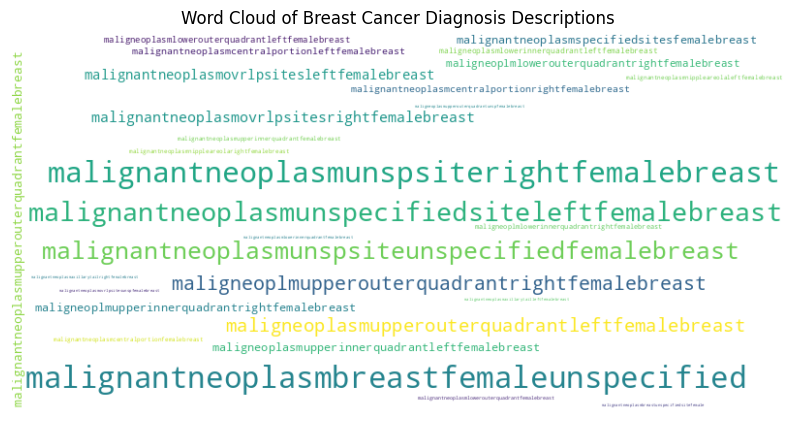

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all breast cancer diagnosis descriptions into a single string
text = ' '.join(train['clean_breast_cancer_diagnosis_desc'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Breast Cancer Diagnosis Descriptions')
plt.show()


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

# Fit and transform the cleaned breast cancer diagnosis description column
encoded_breast_cancer_desc = one_hot_encoder.fit_transform(train[['clean_breast_cancer_diagnosis_desc']])

# Convert the encoded result into a DataFrame
encoded_df = pd.DataFrame(encoded_breast_cancer_desc, columns=one_hot_encoder.get_feature_names_out(['clean_breast_cancer_diagnosis_desc']))

# Concatenate the encoded DataFrame with the original DataFrame
train = pd.concat([train, encoded_df], axis=1)

# Drop the original column after encoding
train.drop('clean_breast_cancer_diagnosis_desc', axis=1, inplace=True)

%config NotebookApp.iopub_data_rate_limit=10000000

train.head(2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



patient_id patient_race  payer_type_0  payer_type_1  payer_type_2  \
0      475714        White             0             0             1   
1      349367        White             0             1             0   

   patient_state_0  patient_state_1  patient_state_2  patient_state_3  \
0                0                0                0                0   
1                0                0                0                0   

   patient_state_4  patient_state_5  patient_zip3_0  patient_zip3_1  \
0                0                1               0               0   
1                0                1               0               0   

   patient_zip3_2  patient_zip3_3  patient_zip3_4  patient_zip3_5  \
0               0               0               0               0   
1               0               0               0               0   

   patient_zip3_6  patient_zip3_7  patient_zip3_8  patient_zip3_9  \
0               0               0               0               1   
1               0               0               1               0   

   patient_age patient_gender        bmi  breast_cancer_diagnosis_code_0  \
0           84              F  28.984539                               0   
1           62              F  28.490000                               0   

   breast_cancer_diagnosis_code_1  breast_cancer_diagnosis_code_2  \
0                               0                               0   
1                               0                               0   

   breast_cancer_diagnosis_code_3  breast_cancer_diagnosis_code_4  \
0                               0                               0   
1                               0                               1   

   breast_cancer_diagnosis_code_5  \
0                               1   
1                               0   

                        breast_cancer_diagnosis_desc  \
0  Malignant neoplasm of unsp site of unspecified...   
1  Malig neoplm of upper-outer quadrant of right ...   

   metastatic_cancer_diagnosis_code_0  metastatic_cancer_diagnosis_code_1  \
0                                   0                                   0   
1                                   0                                   0   

   metastatic_cancer_diagnosis_code_2  metastatic_cancer_diagnosis_code_3  \
0                                   0                                   0   
1                                   0                                   0   

   metastatic_cancer_diagnosis_code_4  metastatic_cancer_diagnosis_code_5  \
0                                   0                                   1   
1                                   1                                   0   

  metastatic_first_novel_treatment metastatic_first_novel_treatment_type  \
0                    PEMBROLIZUMAB                       Antineoplastics   
1                    PEMBROLIZUMAB                       Antineoplastics   

   Region_0  Region_1  Region_2  Division_0  Division_1  Division_2  \
0         0         0         1           0           0           0   
1         0         0         1           0           0           0   

   Division_3   population      density  age_median  age_under_10  \
0           1  31437.75000  1189.562500   30.642857     16.014286   
1           1  39121.87879  2295.939394   38.200000     11.878788   

   age_10_to_19    age_20s    age_30s    age_40s    age_50s    age_60s  \
0     15.542857  17.614286  14.014286  11.614286  11.557143   7.571429   
1     13.354545  14.230303  13.418182  13.333333  14.060606  10.248485   

    age_70s  age_over_80       male     female    married   divorced  \
0  4.000000      2.10000  49.857143  50.142857  36.571429  11.885714   
1  5.951515      3.50303  49.893939  50.106061  50.245455   9.827273   

   never_married   widowed  family_size  family_dual_income  \
0      47.114286  4.442857     3.928571           52.228571   
1      35.290909  4.651515     3.622727           61.736364   

   income_household_median  incom

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

# Fit and transform the cleaned breast cancer diagnosis description column
encoded_breast_cancer_desc = one_hot_encoder.fit_transform(test[['clean_breast_cancer_diagnosis_desc']])

# Convert the encoded result into a DataFrame
encoded_df = pd.DataFrame(encoded_breast_cancer_desc, columns=one_hot_encoder.get_feature_names_out(['clean_breast_cancer_diagnosis_desc']))

# Concatenate the encoded DataFrame with the original DataFrame
test = pd.concat([test, encoded_df], axis=1)

# Drop the original column after encoding
test.drop('clean_breast_cancer_diagnosis_desc', axis=1, inplace=True)

%config NotebookApp.iopub_data_rate_limit=10000000

test.head(2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



patient_id patient_race  payer_type_0  payer_type_1  patient_state_0  \
0      573710        White             0             1                0   
1      593679        White             1             0                0   

   patient_state_1  patient_state_2  patient_state_3  patient_state_4  \
0                0                0                0                0   
1                0                0                0                1   

   patient_state_5  patient_zip3_0  patient_zip3_1  patient_zip3_2  \
0                1               0               0               0   
1                0               0               0               0   

   patient_zip3_3  patient_zip3_4  patient_zip3_5  patient_zip3_6  \
0               0               0               0               0   
1               0               0               0               0   

   patient_zip3_7  patient_zip3_8  patient_zip3_9  patient_age patient_gender  \
0               0               0               1           54              F   
1               0               1               0           52              F   

         bmi  breast_cancer_diagnosis_code_0  breast_cancer_diagnosis_code_1  \
0  28.900073                               0                               0   
1  28.900073                               0                               0   

   breast_cancer_diagnosis_code_2  breast_cancer_diagnosis_code_3  \
0                               0                               0   
1                               0                               0   

   breast_cancer_diagnosis_code_4  breast_cancer_diagnosis_code_5  \
0                               0                               1   
1                               1                               0   

                        breast_cancer_diagnosis_desc  \
0  Malig neoplasm of upper-outer quadrant of left...   
1  Malignant neoplasm of unspecified site of left...   

   metastatic_cancer_diagnosis_code_0  metastatic_cancer_diagnosis_code_1  \
0                                   0                                   0   
1                                   0                                   0   

   metastatic_cancer_diagnosis_code_2  metastatic_cancer_diagnosis_code_3  \
0                                   0                                   0   
1                                   0                                   0   

   metastatic_cancer_diagnosis_code_4  metastatic_cancer_diagnosis_code_5  \
0                                   0                                   1   
1                                   1                                   0   

  metastatic_first_novel_treatment metastatic_first_novel_treatment_type  \
0                    PEMBROLIZUMAB                       Antineoplastics   
1                    PEMBROLIZUMAB                       Antineoplastics   

   Region_0  Region_1  Region_2  Division_0  Division_1  Division_2  \
0         0         0         1           0           0           0   
1         0         1         0           0           0           1   

   Division_3    population      density  age_median  age_under_10  \
0           1   5441.435484    85.620968   40.880328     12.732258   
1           0  19613.820510  1555.107692   49.107692      8.069231   

   age_10_to_19    age_20s    age_30s    age_40s    age_50s    age_60s  \
0     14.088710  10.659677  11.625806  11.208065  15.619355  12.322581   
1      8.587179  10.684615  11.302564  10.971795  15.823077  15.902564   

     age_70s  age_over_80       male     female    married   divorced  \
0   8.409677     3.343548  49.154839  50.845161  55.175806  13.982258   
1  11.828205     6.815385  49.658974  50.341026  44.800000  17.779487   

   never_married   widowed  family_size  family_dual_income  \
0      24.266129  6.583871     3.073226           52.980645   
1      29.102564  8.310256     2.917105           46.665789   

   income_household_median  income_household_under_5  \
0              66187.22807   

In [ ]:
test = test.drop(columns = [
                              'patient_gender',
                              'patient_race',
                               'clean_breast_cancer_diagnosis_desc_stopwords_removed',
                               'breast_cancer_diagnosis_desc',
                              'metastatic_first_novel_treatment',
                      'metastatic_first_novel_treatment_type'])

test.head(2) #Confirming successful column drop

patient_id  payer_type_0  payer_type_1  patient_state_0  patient_state_1  \
0      573710             0             1                0                0   
1      593679             1             0                0                0   

   patient_state_2  patient_state_3  patient_state_4  patient_state_5  \
0                0                0                0                1   
1                0                0                1                0   

   patient_zip3_0  patient_zip3_1  patient_zip3_2  patient_zip3_3  \
0               0               0               0               0   
1               0               0               0               0   

   patient_zip3_4  patient_zip3_5  patient_zip3_6  patient_zip3_7  \
0               0               0               0               0   
1               0               0               0               0   

   patient_zip3_8  patient_zip3_9  patient_age        bmi  \
0               0               1           54  28.900073   
1               1               0           52  28.900073   

   breast_cancer_diagnosis_code_0  breast_cancer_diagnosis_code_1  \
0                               0                               0   
1                               0                               0   

   breast_cancer_diagnosis_code_2  breast_cancer_diagnosis_code_3  \
0                               0                               0   
1                               0                               0   

   breast_cancer_diagnosis_code_4  breast_cancer_diagnosis_code_5  \
0                               0                               1   
1                               1                               0   

   metastatic_cancer_diagnosis_code_0  metastatic_cancer_diagnosis_code_1  \
0                                   0                                   0   
1                                   0                                   0   

   metastatic_cancer_diagnosis_code_2  metastatic_cancer_diagnosis_code_3  \
0                                   0                                   0   
1                                   0                                   0   

   metastatic_cancer_diagnosis_code_4  metastatic_cancer_diagnosis_code_5  \
0                                   0                                   1   
1                                   1                                   0   

   Region_0  Region_1  Region_2  Division_0  Division_1  Division_2  \
0         0         0         1           0           0           0   
1         0         1         0           0           0           1   

   Division_3    population      density  age_median  age_under_10  \
0           1   5441.435484    85.620968   40.880328     12.732258   
1           0  19613.820510  1555.107692   49.107692      8.069231   

   age_10_to_19    age_20s    age_30s    age_40s    age_50s    age_60s  \
0     14.088710  10.659677  11.625806  11.208065  15.619355  12.322581   
1      8.587179  10.684615  11.302564  10.971795  15.823077  15.902564   

     age_70s  age_over_80       male     female    married   divorced  \
0   8.409677     3.343548  49.154839  50.845161  55.175806  13.982258   
1  11.828205     6.815385  49.658974  50.341026  44.800000  17.779487   

   never_married   widowed  family_size  family_dual_income  \
0      24.266129  6.583871     3.073226           52.980645   
1      29.102564  8.310256     2.917105           46.665789   

   income_household_median  income_household_under_5  \
0              66187.22807                  1.611290   
1              64711.71053                  3.873684   

   income_household_5_to_10  income_household_10_to_15  \
0                  1.277419                   2.645161   
1                  2.044737                   3.807895   

   income_household_15_to_20  income_household_20_to_25  \
0                   3.853226                   3.172581   
1                   4.239474                   4.242105   

   income_household_25_to_35  income_househol

In [ ]:
train = train.drop(columns = ['patient_id',
                              'patient_gender',
                              'patient_race',
                               'clean_breast_cancer_diagnosis_desc_stopwords_removed',
                               'breast_cancer_diagnosis_desc',
                              'metastatic_first_novel_treatment',
                      'metastatic_first_novel_treatment_type'])

train.head(2) #Confirming successful column drop

payer_type_0  payer_type_1  payer_type_2  patient_state_0  patient_state_1  \
0             0             0             1                0                0   
1             0             1             0                0                0   

   patient_state_2  patient_state_3  patient_state_4  patient_state_5  \
0                0                0                0                1   
1                0                0                0                1   

   patient_zip3_0  patient_zip3_1  patient_zip3_2  patient_zip3_3  \
0               0               0               0               0   
1               0               0               0               0   

   patient_zip3_4  patient_zip3_5  patient_zip3_6  patient_zip3_7  \
0               0               0               0               0   
1               0               0               0               0   

   patient_zip3_8  patient_zip3_9  patient_age        bmi  \
0               0               1           84  28.984539   
1               1               0           62  28.490000   

   breast_cancer_diagnosis_code_0  breast_cancer_diagnosis_code_1  \
0                               0                               0   
1                               0                               0   

   breast_cancer_diagnosis_code_2  breast_cancer_diagnosis_code_3  \
0                               0                               0   
1                               0                               0   

   breast_cancer_diagnosis_code_4  breast_cancer_diagnosis_code_5  \
0                               0                               1   
1                               1                               0   

   metastatic_cancer_diagnosis_code_0  metastatic_cancer_diagnosis_code_1  \
0                                   0                                   0   
1                                   0                                   0   

   metastatic_cancer_diagnosis_code_2  metastatic_cancer_diagnosis_code_3  \
0                                   0                                   0   
1                                   0                                   0   

   metastatic_cancer_diagnosis_code_4  metastatic_cancer_diagnosis_code_5  \
0                                   0                                   1   
1                                   1                                   0   

   Region_0  Region_1  Region_2  Division_0  Division_1  Division_2  \
0         0         0         1           0           0           0   
1         0         0         1           0           0           0   

   Division_3   population      density  age_median  age_under_10  \
0           1  31437.75000  1189.562500   30.642857     16.014286   
1           1  39121.87879  2295.939394   38.200000     11.878788   

   age_10_to_19    age_20s    age_30s    age_40s    age_50s    age_60s  \
0     15.542857  17.614286  14.014286  11.614286  11.557143   7.571429   
1     13.354545  14.230303  13.418182  13.333333  14.060606  10.248485   

    age_70s  age_over_80       male     female    married   divorced  \
0  4.000000      2.10000  49.857143  50.142857  36.571429  11.885714   
1  5.951515      3.50303  49.893939  50.106061  50.245455   9.827273   

   never_married   widowed  family_size  family_dual_income  \
0      47.114286  4.442857     3.928571           52.228571   
1      35.290909  4.651515     3.622727           61.736364   

   income_household_median  income_household_under_5  \
0              52996.28571                  3.142857   
1             102741.63640                  2.327273   

   income_household_5_to_10  income_household_10_to_15  \
0                  4.000000                   6.157143   
1                  1.536364                   2.648485   

   income_household_15_to_20  income_household_20_to_25  \
0                   5.142857                   6.271429   
1                   2.178788                   2.409091   

   income_household_25_to_35  income_househol

Data balance check

In [ ]:
# Calculate the proportion of each class
class_proportions = train['DiagPeriodL90D'].value_counts(normalize=True)

# Display the class proportions
print("Class Proportions:")
print(class_proportions)

# Calculate the balance ratio
balance_ratio = class_proportions[1] / class_proportions[0]

# Display the balance ratio
print("Balance Ratio (class 1 / class 0):", balance_ratio)


Class Proportions:
1    0.624516
0    0.375484
Name: DiagPeriodL90D, dtype: float64
Balance Ratio (class 1 / class 0): 1.663227404044573


model

In [ ]:
X_train_full = train.drop(columns=['DiagPeriodL90D']) if 'DiagPeriodL90D' in train.columns else train
y_train_full = train['DiagPeriodL90D'] if 'DiagPeriodL90D' in train.columns else None
X_test = test.drop(columns=['DiagPeriodL90D']) if 'DiagPeriodL90D' in test.columns else test

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
missing_columns = set(X_train.columns) - set(X_test.columns)
for column in missing_columns:
    X_test[column] = 0  # Fill missing columns with zeros

X_test = X_test[X_train.columns]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [ ]:
catboost_model = CatBoostClassifier(class_weights=class_weights)
lgbm_model = LGBMClassifier(class_weight='balanced')
xgb_model = XGBClassifier(scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1))

In [ ]:
catboost_model.fit(X_train_scaled, y_train)
lgbm_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)

Learning rate set to 0.027916
0:	learn: 0.6821136	total: 108ms	remaining: 1m 47s
1:	learn: 0.6714801	total: 151ms	remaining: 1m 15s
2:	learn: 0.6612839	total: 190ms	remaining: 1m 3s
3:	learn: 0.6520744	total: 239ms	remaining: 59.4s
4:	learn: 0.6433202	total: 280ms	remaining: 55.8s
5:	learn: 0.6349815	total: 319ms	remaining: 52.9s
6:	learn: 0.6277396	total: 360ms	remaining: 51.1s
7:	learn: 0.6207307	total: 407ms	remaining: 50.5s
8:	learn: 0.6145241	total: 453ms	remaining: 49.9s
9:	learn: 0.6085649	total: 482ms	remaining: 47.7s
10:	learn: 0.6025797	total: 508ms	remaining: 45.6s
11:	learn: 0.5969552	total: 536ms	remaining: 44.1s
12:	learn: 0.5915019	total: 571ms	remaining: 43.3s
13:	learn: 0.5860539	total: 612ms	remaining: 43.1s
14:	learn: 0.5814856	total: 660ms	remaining: 43.3s
15:	learn: 0.5775152	total: 702ms	remaining: 43.2s
16:	learn: 0.5743068	total: 748ms	remaining: 43.2s
17:	learn: 0.5709136	total: 789ms	remaining: 43s
18:	learn: 0.5680960	total: 832ms	remaining: 43s
19:	learn: 0.

In [ ]:
# Generate predictions for the validation dataset
catboost_pred_val = catboost_model.predict_proba(X_val_scaled)[:, 1]
lgbm_pred_val = lgbm_model.predict_proba(X_val_scaled)[:, 1]
xgb_pred_val = xgb_model.predict_proba(X_val_scaled)[:, 1]

In [ ]:
# Ensemble predictions for validation dataset
ensemble_pred_val = (catboost_pred_val + lgbm_pred_val + xgb_pred_val) / 3

In [ ]:
# Calculate accuracy for each model on the validation set
catboost_accuracy_val = accuracy_score(y_val, catboost_model.predict(X_val_scaled))
lgbm_accuracy_val = accuracy_score(y_val, lgbm_model.predict(X_val_scaled))
xgb_accuracy_val = accuracy_score(y_val, xgb_model.predict(X_val_scaled))
ensemble_accuracy_val = accuracy_score(y_val, np.round(ensemble_pred_val))

In [ ]:
# Print accuracy for each model on the validation set
print("CatBoost Validation Accuracy:", catboost_accuracy_val)
print("LGBM Validation Accuracy:", lgbm_accuracy_val)
print("XGBoost Validation Accuracy:", xgb_accuracy_val)
print("Ensemble Validation Accuracy:", ensemble_accuracy_val)

CatBoost Validation Accuracy: 0.8040278853601859
LGBM Validation Accuracy: 0.7989930286599535
XGBoost Validation Accuracy: 0.7773044151820294
Ensemble Validation Accuracy: 0.7982184353214562


In [ ]:
# Define models, accuracies, and additional information
models = ['CatBoost', 'LGBM', 'XGBoost', 'Ensemble']
accuracies = [catboost_accuracy_val, lgbm_accuracy_val, xgb_accuracy_val, ensemble_accuracy_val]
descriptions = ['CatBoost Classifier', 'LightGBM Classifier', 'XGBoost Classifier', 'Ensemble of all three models']

# Define colors for each model
colors = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)', 'rgb(148, 103, 189)']

# Create bar plot
fig1 = go.Figure(data=[go.Bar(x=models, y=accuracies, marker_color=colors,
                              text=descriptions, textposition='auto')])
fig1.update_layout(title='Accuracy of Ensemble Models', xaxis_title='Models', yaxis_title='Accuracy',
                   yaxis=dict(range=[0, 1]), template='plotly_dark')
fig1.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, ensemble_pred_val)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC={roc_auc:.2f})',
                          line=dict(color='orange', width=2)))
fig2.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash', color='navy')))
fig2.update_layout(title='Receiver Operating Characteristic (ROC) Curve', xaxis_title='False Positive Rate',
                   yaxis_title='True Positive Rate', template='plotly_dark')
fig2.show()

In [ ]:
# Generate predictions for the test dataset
catboost_pred_test = catboost_model.predict_proba(X_test_scaled)[:, 1]
lgbm_pred_test = lgbm_model.predict_proba(X_test_scaled)[:, 1]
xgb_pred_test = xgb_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Ensemble predictions for test dataset
ensemble_pred_test = (catboost_pred_test + lgbm_pred_test + xgb_pred_test) / 3
# Convert predictions to percentages
ensemble_pred_test_percent = ensemble_pred_test * 100

In [ ]:
# Create a submission dataframe with patient IDs and predictions for the test dataset
submission_df = pd.DataFrame({
    'patient_id': test['patient_id'],
    'DiagPeriodL90D': ensemble_pred_test_percent
})



In [ ]:
# Save the submission dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)